In [1]:
# Import packages and set working directory if needed here
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from rasterio.merge import merge
from rasterio.plot import show # may not keep this import
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl
from shapely.geometry import mapping, box
from shapely.geometry import Polygon

import common_functions as common

# set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Open 2011 mosaic file
mosaic_2011_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2011_mosaic_crop.tif"
with rio.open(mosaic_2011_fp) as mosaic_2011_src:
    mosaic_2011_scene = mosaic_2011_src.read()
    mosaic_2011_scene_meta = mosaic_2011_src.meta
    mosaic_2011_scene_bds = mosaic_2011_src.bounds
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(mosaic_2011_src.crs)
    masked_mosaic_2011, masked_mosaic_2011_affine = mask(mosaic_2011_src, study_area_box_reprojected.geometry, crop=True)

In [3]:
# Open 2014 mosaic file
mosaic_2014_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2014_mosaic_crop.tif"
with rio.open(mosaic_2014_fp) as mosaic_2014_src:
    mosaic_2014_scene = mosaic_2014_src.read()
    mosaic_2014_scene_meta = mosaic_2014_src.meta
    mosaic_2014_scene_bds = mosaic_2014_src.bounds
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(mosaic_2014_src.crs)
    masked_mosaic_2014, masked_mosaic_2014_affine = mask(mosaic_2014_src, study_area_box_reprojected.geometry, crop=True)

In [4]:
# Open site boundary shapefile
clip_out_path = "data/final-project/cottonwood-heights-utah/vector-clip/utah-avalanche-clip.shp"
avalanche_boundary = gpd.read_file(clip_out_path)

In [5]:
# Open avalanche paths
avalanche_paths_filename = glob(os.path.join(
    'data', 'final-project', 'cottonwood-heights-utah', 'avalanche-paths', '*.shp'))
avalanche_paths = gpd.read_file(avalanche_paths_filename[0])

# Clip paths to site boundary
avalanche_clip = cl.clip_shp(avalanche_paths, avalanche_boundary)

## Compute NDVI, Average NDVI, and Plot them

In [6]:
# Convert the data to int to avoid the divide by zero error
mosaic_2011_scene = mosaic_2011_scene.astype(int)
mosaic_2014_scene = mosaic_2014_scene.astype(int)
# Compute NDVI
ndvi_2011_mosaic = es.normalized_diff(b2=mosaic_2011_scene[3], b1=mosaic_2011_scene[2])
ndvi_2014_mosaic = es.normalized_diff(b2=mosaic_2014_scene[3], b1=mosaic_2014_scene[2])

C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\earthpy\spatial.py:75: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b2 - b1) / (b2 + b1)


In [7]:
# Compute average NAIP 2011 NDVI within avalanche paths and outside avi paths
avalanche_overlap_shape = common.generate_unioned_avalanche_overlay(mosaic_2011_src.crs)
merged_results_ndvi_2011 = common.rasterstats_grouped_by_height(avalanche_overlap_shape,
                                                                ndvi_2011_mosaic,
                                                                masked_mosaic_2011_affine,
                                                                "mean")

C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\rasterstats\io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


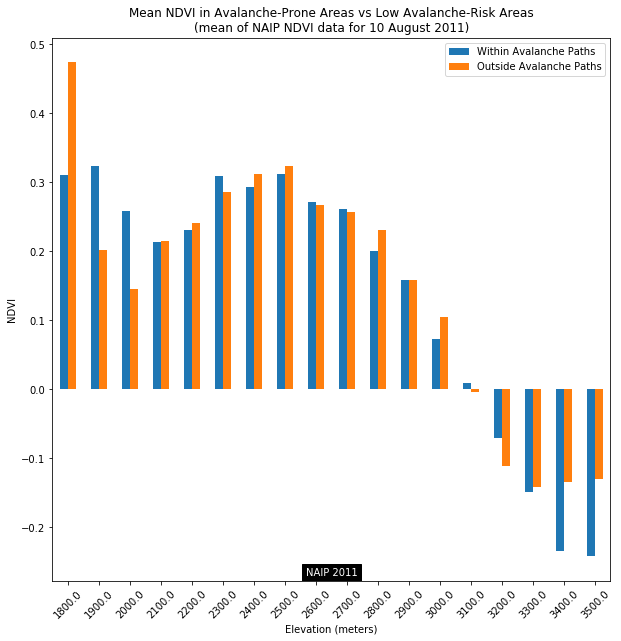

In [8]:
# Plot the average NAIP 2011 NDVI within and outside the avi paths
common.plot_bar(merged_results_ndvi_2011[merged_results_ndvi_2011['height_bucket'] != 0],
                "height_bucket",
                "Elevation (meters)",
                ['mean_avalanche', 'mean_no_avalanche'],
                "NDVI",
                "Mean NDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" +
                "(mean of NAIP NDVI data for 10 August 2011)",
                "NAIP 2011", series_names=['Within Avalanche Paths', 'Outside Avalanche Paths'])

In [9]:
# Compute average NAIP 2014 NDVI within avalanche paths and outside avi paths
# Compute average NAIP 2011 NDVI within avalanche paths and outside avi paths
avalanche_overlap_shape = common.generate_unioned_avalanche_overlay(mosaic_2014_src.crs)
merged_results_ndvi_2014 = common.rasterstats_grouped_by_height(avalanche_overlap_shape,
                                                                ndvi_2014_mosaic,
                                                                masked_mosaic_2014_affine,
                                                                "mean")

C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\rasterstats\io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


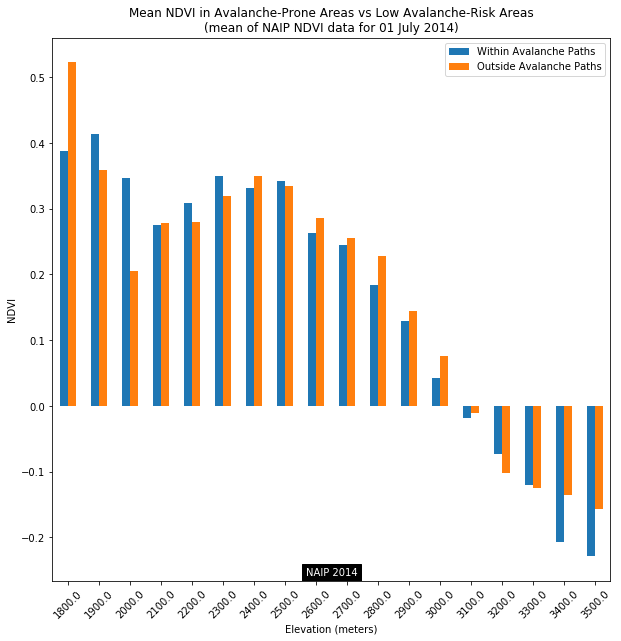

In [10]:
# Plot the average NAIP 2014 NDVI within and outside the avi paths
common.plot_bar(merged_results_ndvi_2014[merged_results_ndvi_2014['height_bucket'] != 0],
                "height_bucket",
                "Elevation (meters)",
                ['mean_avalanche', 'mean_no_avalanche'],
                "NDVI",
                "Mean NDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" +
                "(mean of NAIP NDVI data for 01 July 2014)",
                "NAIP 2014", series_names=['Within Avalanche Paths', 'Outside Avalanche Paths'])

## PLot the NDVI Mosaic with the Avalanche Paths and Site Boundary

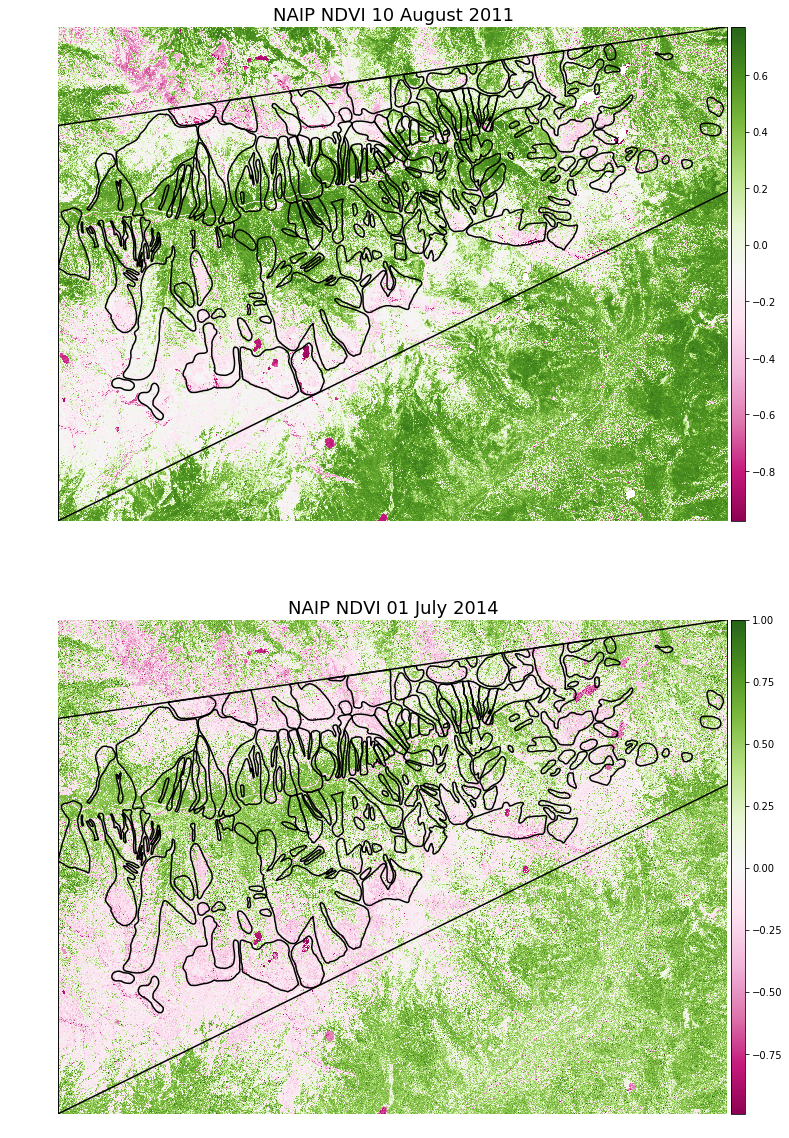

In [12]:
mosaic_extent = plotting_extent(mosaic_2011_src)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
# Plot the 2011 NDVI mosaic
mos_2011 = ax1.imshow(ndvi_2011_mosaic, cmap="PiYG",
                 extent=mosaic_extent)

# Set up colorbar, title, caption, and axis
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(mos_2011, cax=cax)
ax1.set_title('NAIP NDVI 10 August 2011', fontsize=18)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="black")
avalanche_clip.boundary.plot(ax=ax1, color="black")


# Plot the 2011 NDVI mosaic
mos_2014 = ax2.imshow(ndvi_2014_mosaic, cmap="PiYG",
                 extent=mosaic_extent)

# Set up colorbar, title, caption, and axis
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(mos_2014, cax=cax)
ax2.set_title('NAIP NDVI 01 July 2014', fontsize=18)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax2, color="black")
avalanche_clip.boundary.plot(ax=ax2, color="black")
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

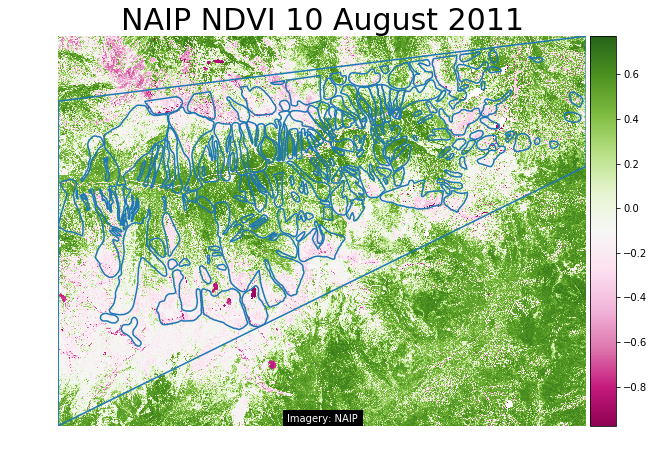

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25bb698b6a0>)

In [14]:
# Try out the common_functions plot_array_and_vector function
common.plot_array_and_vector(ndvi_2011_mosaic,
                             mosaic_2011_src.crs,
                             "NAIP NDVI 10 August 2011",
                             "Imagery: NAIP")